## Carbon-I Testbed Prototype

A prototype instrument has already been developed at JPL to demonstrate the Carbon-I measurement concept. This **testbed** incorporates a Dyson block, grating, and focal-plane array (FPA) matching Carbon-I’s anticipated optical design and performance specifications. Through laboratory measurements, the testbed can validate key elements such as **spectral resolution**, **imaging fidelity**, **throughput**, and **straylight** characteristics. These  demonstrations can confirm that Carbon-I’s architecture is both **technically feasible** and **robust**, ensuring confidence as we proceed toward a flight-ready instrument. 

In its current setup, the **testbed spectra** are measured under a **warm environment**, so the system is not fully aligned at flight operating temperatures. Consequently, the **spectral response function (SRF)** in these early demonstrations will appear more **fuzzy** than what we expect under cold, flight-like alignment conditions—a refinement that will be investigated in subsequent testbed campaigns.

---

Below, we walk through the **testbed-spectra fitting** procedure using measurements from a **light source** paired with a **CH<sub>4</sub> gas cell**. All examples here leverage the **Julia** programming language, chosen for its **high-level syntax** and **near-C speed**, making it ideally suited for the **Carbon-I** data processing pipeline. 

> First, we need to import some packages in Julia

In [1]:
using Pkg
Pkg.activate("../.."); # Actives the environment at the root of the project
# Using our Carbon-I and vSmartMOM packages (developed by our team)
using CarbonI, vSmartMOM
# Using standard Julia packages for Linear albegra, Differentiation, etc.
using SpecialPolynomials, FiniteDiff, LinearAlgebra
using DelimitedFiles, ImageFiltering, ForwardDiff, DiffResults, Polynomials
# Using the Makie package for plotting
using CairoMakie
include(joinpath("../../src/Plots", "CI_colorsNew.jl"))

  Activating project at `~/code/gitHub/CarbonI`
┌ Info: CUDA-enabled GPU(s) detected
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:57
┌ Info: CUDA.CuDevice(0): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:59
┌ Info: CUDA.CuDevice(1): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:59


pwd()

> Reading in the testbed spectra, stored as simple CSV file:

In [2]:
testbed_ch4 = readdlm("../../data/CITB/20250408 CITB CH4.csv",',');
testbed_co = readdlm("../../data/CITB/20250408 CITB CO.csv",',');
testbed_c2h6 = readdlm("../../data/CITB/20250408 CITB C2H6.csv",',');
testbed_co2 = readdlm("../../data/CITB/20250408 CITB CO2.csv",',');
testbed_n2o = readdlm("../../data/CITB/20250408 CITB NO.csv",',');

pCO2 =  fit(testbed_co2[50:end,1], testbed_co2[50:end,2], 5)

Polynomial(-2.5212049026523424e-10 - 2.2454725454440428e-7*x - 0.00012506701065888098*x^2 + 1.6690516659038296e-7*x^3 - 7.396046809879673e-11*x^4 + 1.0898907957704283e-14*x^5)

In [3]:
set_theme!(theme_ggplot2())

In [4]:
function plotSpectra()
    f = Figure(resolution = (550, 320), backgroundcolor=:transparent)
    
    ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Scaled Transmission", title="CIDU Measurements")
    
    lines!(ax,  testbed_ch4[:,1],(testbed_ch4[:,2]*1.2)/2 .+0.45, color = CarbonI_colors[1], linewidth = 2.0, label = "CH₄")
    lines!(ax,  testbed_co[370:end,1],(testbed_co[370:end,2]/5).+0.815, color = CarbonI_colors[3], linewidth = 2.0, label = "CO")
    #lines!(ax,  testbed_c2h6[:,1],testbed_c2h6[:,2], color = CarbonI_colors[5], linewidth = 2.0, label = "C₂H₆ gas cell")
    lines!(ax,  testbed_co2[1:150,1],4(testbed_co2[1:150,2]./pCO2.(testbed_co2[1:150,1])).-3.05, color = CarbonI_colors[2], linewidth = 2.0, label = "CO₂")
    lines!(ax,  testbed_n2o[:,1],(testbed_n2o[:,2]/8) .+ 0.89, color = CarbonI_colors[4], linewidth = 2.0, label = "N₂O")
    lines!(ax,[2040; 2368], [1.05; 1.05] ,  color = :red, linewidth = 2, label="REQ")
    lines!(ax,[2040; 2040], [1.04; 1.06] ,  color = :red, linewidth = 1)
    lines!(ax,[2368; 2368], [1.04; 1.06] ,  color = :red, linewidth = 1)

    lines!(ax,[2036; 2372], [1.05; 1.05].+0.03 ,  color = :black, linewidth = 2, label="CBE")
    lines!(ax,[2036; 2036], [1.04; 1.06].+0.03 ,  color = :black, linewidth = 1)
    lines!(ax,[2372; 2372], [1.04; 1.06].+0.03 ,  color = :black, linewidth = 1)

    axislegend(ax,position = :cb, orientation=:horizontal)
    xlims!(ax, 2030, 2380)
    f
end

plotSpectra (generic function with 1 method)

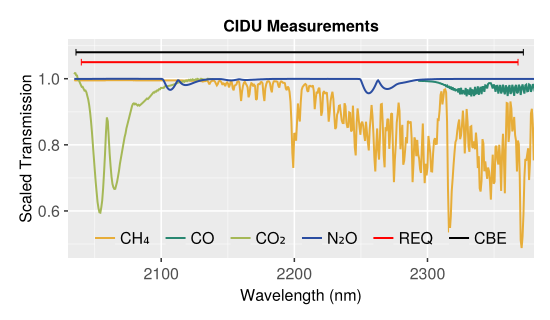

In [5]:
f = plotSpectra()
save("../../plots/final/FO-E1-Protoype_Scaled_Transmissions.pdf", f)
f

In [13]:
function plotSpectra2()
    f = Figure(resolution = (650, 320), backgroundcolor=:transparent)
    
    ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Gas Cell Transmission", title="CIDU Measurements")
    
    ch4 = testbed_ch4[:,2]
    co = testbed_co[370:end,2]
    c2h6 = testbed_c2h6[:,2]
    co2 = testbed_co2[1:150,2]./pCO2.(testbed_co2[1:150,1])
    n2o = testbed_n2o[:,2]

    lines!(ax,  testbed_ch4[:,1],ch4./maximum(ch4), color = CarbonI_colors[1], linewidth = 2.0, label = "CH₄")
    lines!(ax,  testbed_co[370:end,1],co/maximum(co), color = CarbonI_colors[3], linewidth = 2.0, label = "CO")
    lines!(ax,  testbed_c2h6[:,1],c2h6/maximum(c2h6), color = CarbonI_colors[5], linewidth = 2.0, label = "C₂H₆")
    lines!(ax,  testbed_co2[1:150,1],co2/maximum(co2), color = CarbonI_colors[2], linewidth = 2.0, label = "CO₂")
    lines!(ax,  testbed_n2o[:,1],n2o/maximum(n2o), color = CarbonI_colors[4], linewidth = 2.0, label = "N₂O")
  

    axislegend(ax,position = :cb, orientation=:horizontal)
    xlims!(ax, 2030, 2380)
    f
end

plotSpectra2 (generic function with 1 method)

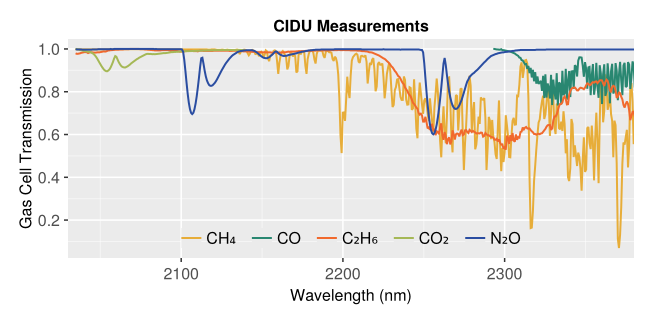

In [14]:
f = plotSpectra2()

save("../../plots/final/Box-E1-CIDU_Transmissions.pdf", f)
f